In [278]:
from scipy.io import loadmat
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


%matplotlib inline

In [2]:
filelist = ["calcium_data/140708B_140811a_result", 
            "calcium_data/140909C_141112a_result", 
            "calcium_data/141006C_141121a_result",
            "calcium_data/150109A_150302a_result", 
            "calcium_data/151122A_160202a_result", 
            "calcium_data/151122B_160207a_result", 
            "calcium_data/160209A_160430a_result", 
            "calcium_data/160209B_160428a_result"]

In [3]:
filename = filelist[0]
f = h5py.File(filename+".hdf5", "r")

In [177]:
#average delta F
#1s = 59 frames
data = f['data']
meta = f['meta']

amp = 2
site = 50

mn_dnd_chng = np.mean(data[:,:,:60], axis=2)

present_mask = meta[:,1]==amp
absent_mask = meta[:,1]==0

In [178]:
present = mn_dnd_chng[present_mask,site]
absent = mn_dnd_chng[absent_mask,site]

min_crit = np.min(absent)
max_crit = np.max(present)

#histogram stuff
n_hist = 30
delta = (max_crit - min_crit)/n_hist
window = 700

lick_mask = (f['licktimes'][:,0]<window)*(f['licktimes'][:,0]>=0)
#lick_mask = f['meta'][:,2]
nolick_mask = np.logical_not(lick_mask)
#hit_mask = 

d1 = []
d2 = []
for k, i in enumerate(np.arange(min_crit, max_crit, delta)):
    #fetch trials with that value
    geq_mask = mn_dnd_chng[:,site] >= i
    sm_mask = mn_dnd_chng[:,site] < i+delta
    ind_mask = geq_mask*sm_mask
    
    d1.append(np.sum(ind_mask*lick_mask))
    d2.append(np.sum(ind_mask*nolick_mask))

tp = []
fp = []

for crit in np.linspace(min_crit, max_crit, 1000):
    tp.append(np.sum(present>crit)/present.shape[0])
    fp.append(np.sum(absent>crit)/absent.shape[0])

In [256]:
def ROC(filename, amp, site, ax, n_steps=1000):
    f = h5py.File(filename+".hdf5", "r")
    
    #average delta F
    #1s = 59 frames
    data = f['data']
    meta = f['meta']

    mn_dnd_chng = np.mean(data[:,:,:60], axis=2)

    present_mask = meta[:,1]==amp
    absent_mask = meta[:,1]==0
    
    present = mn_dnd_chng[present_mask,site]
    absent = mn_dnd_chng[absent_mask,site]

    min_crit = np.min(absent)
    max_crit = np.max(present)
    
    tp = []
    fp = []

    for crit in np.linspace(min_crit, max_crit, n_steps):
        tp.append(np.sum(present>crit)/present.shape[0])
        fp.append(np.sum(absent>crit)/absent.shape[0])
        
    AUC = auc(fp, tp, reorder=False)
        
    ax.plot(fp, tp)
    ax.plot(np.linspace(0,1,n_steps), np.linspace(0,1,n_steps), color='k', linestyle='--')
    ax.fill_between(fp, np.zeros(n_steps), tp, facecolor="#B09473", alpha=1)
    ax.set_aspect('equal')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    
    return AUC

In [259]:
def ROC_sk(filename, amp, site, ax, n_steps=1000):
    f = h5py.File(filename+".hdf5", "r")
    
    #average delta F
    #1s = 59 frames
    data = f['data']
    meta = f['meta']

    mn_dnd_chng = np.mean(data[:,:,:60], axis=2)

    present_mask = meta[:,1]==amp
    absent_mask = meta[:,1]==0
    
    trials_mask = np.logical_or(present_mask, absent_mask)
    
    y_score = mn_dnd_chng[trials_mask, site]
    
    amp_mask = meta[:,1][trials_mask]==amp
    y_true = (amp_mask-0.5)*2
    
    #present = mn_dnd_chng[present_mask,site]
    #absent = mn_dnd_chng[absent_mask,site]

    #min_crit = np.min(absent)
    #max_crit = np.max(present)
    
    #tp = []
    #fp = []

    #for crit in np.linspace(min_crit, max_crit, n_steps):
    #    tp.append(np.sum(present>crit)/present.shape[0])
    #    fp.append(np.sum(absent>crit)/absent.shape[0])
    
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    AUC = auc(fpr, tpr, reorder=False)
    
    n_steps = thresholds.shape[0]
        
    ax.plot(fpr, tpr)
    ax.plot(np.linspace(0,1,n_steps), np.linspace(0,1,n_steps), color='k', linestyle='--')
    ax.fill_between(fpr, np.zeros(n_steps), tpr, facecolor="#B09473", alpha=1)
    ax.set_aspect('equal')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    
    return AUC

In [288]:
def get_DIs(filename, amp):
    f = h5py.File(filename+".hdf5", "r")
    
    #average delta F
    #1s = 59 frames
    data = f['data']
    meta = f['meta']

    mn_dnd_chng = np.mean(data[:,:,:60], axis=2)

    present_mask = meta[:,1]==amp
    absent_mask = meta[:,1]==0
    
    trials_mask = np.logical_or(present_mask, absent_mask)
    
    amp_mask = meta[:,1][trials_mask]==amp
    y_true = (amp_mask-0.5)*2
    
    DIs = []
    for site in range(data.shape[1]):
        y_score = mn_dnd_chng[trials_mask, site]
    
        DIs.append((roc_auc_score(y_true, y_score)-0.5)*2)
    return DIs

In [306]:
DIs = get_DIs(filelist[4], 1)
print(np.max(DIs), np.min(DIs))

0.22962962963 -0.282962962963


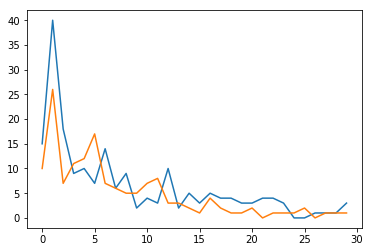

In [240]:
plt.plot(d1)
plt.plot(d2)

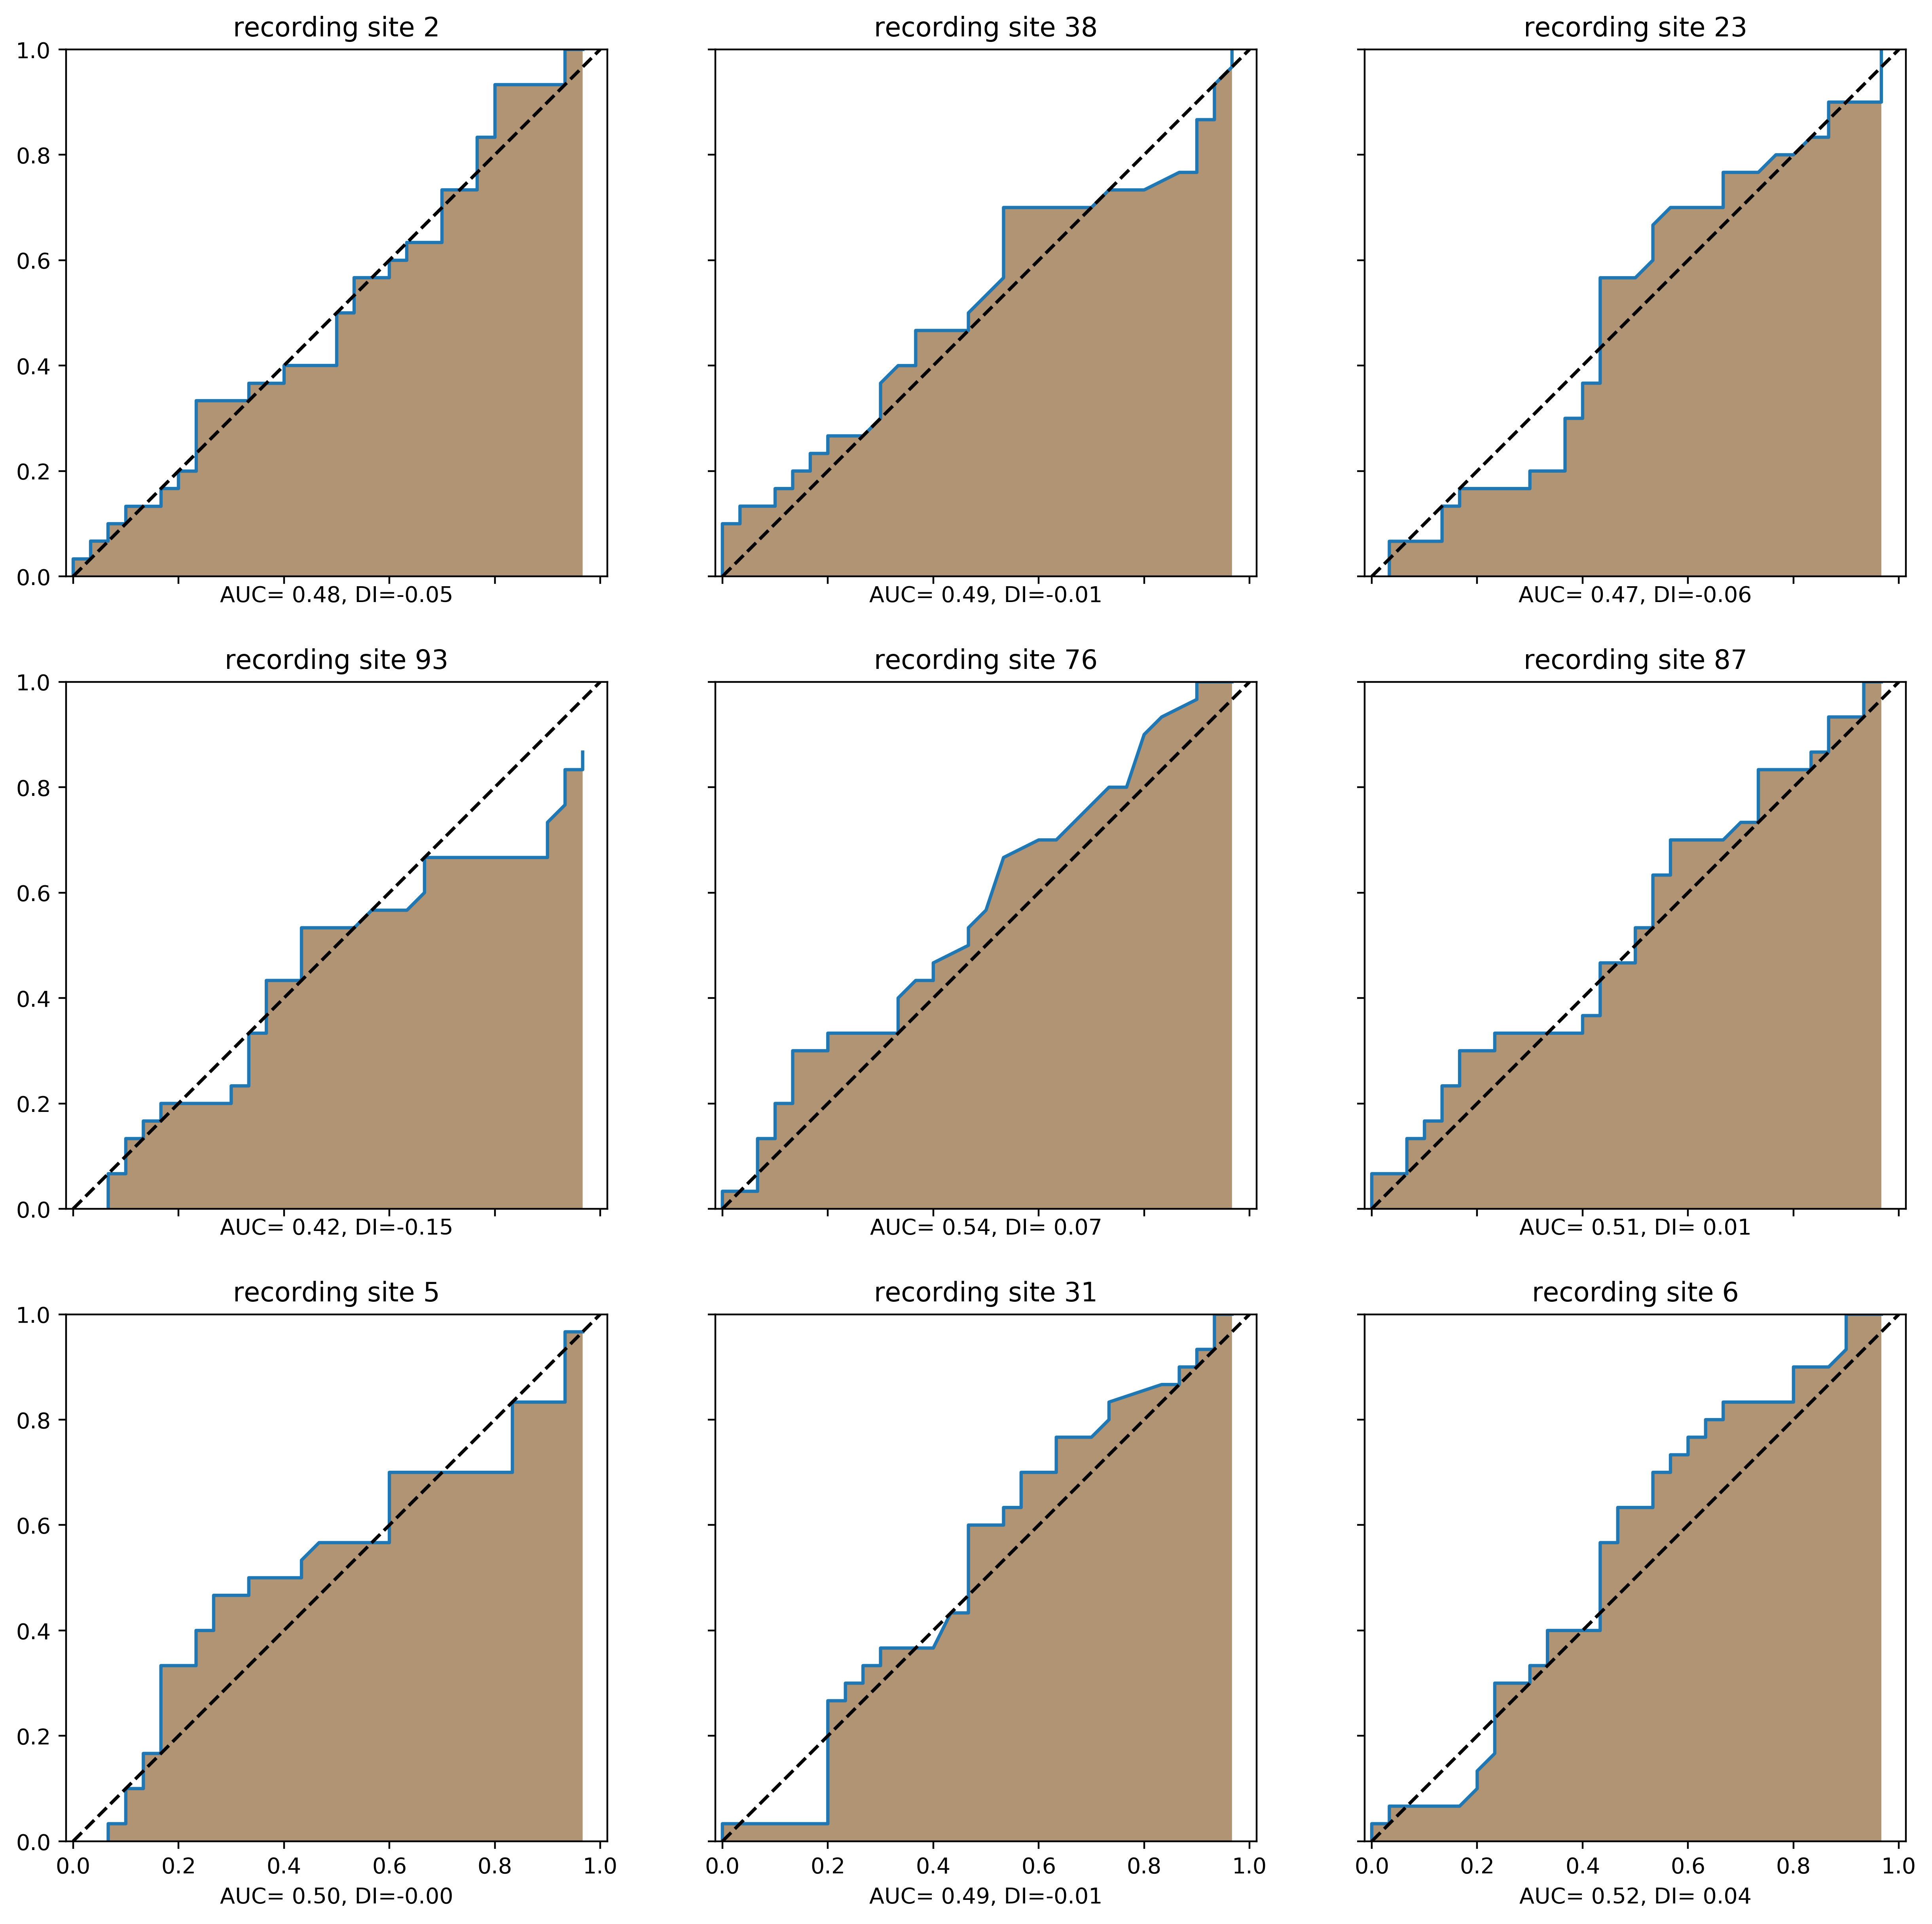

In [276]:
filename = filelist[2]
stim_amp = 2
n_dendrites = h5py.File(filename+".hdf5", "r")['data'].shape[1]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(15,15), dpi=400)
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for k, i in enumerate(np.random.choice(n_dendrites, 9, replace=False)):
    AUC = ROC(filename, stim_amp, i, axes[k])
    axes[k].set_title('recording site {}'.format(i))
    axes[k].set_xlabel('AUC={0: .2f}, DI={1: .2f}'.format(AUC, (AUC-0.5)*2))

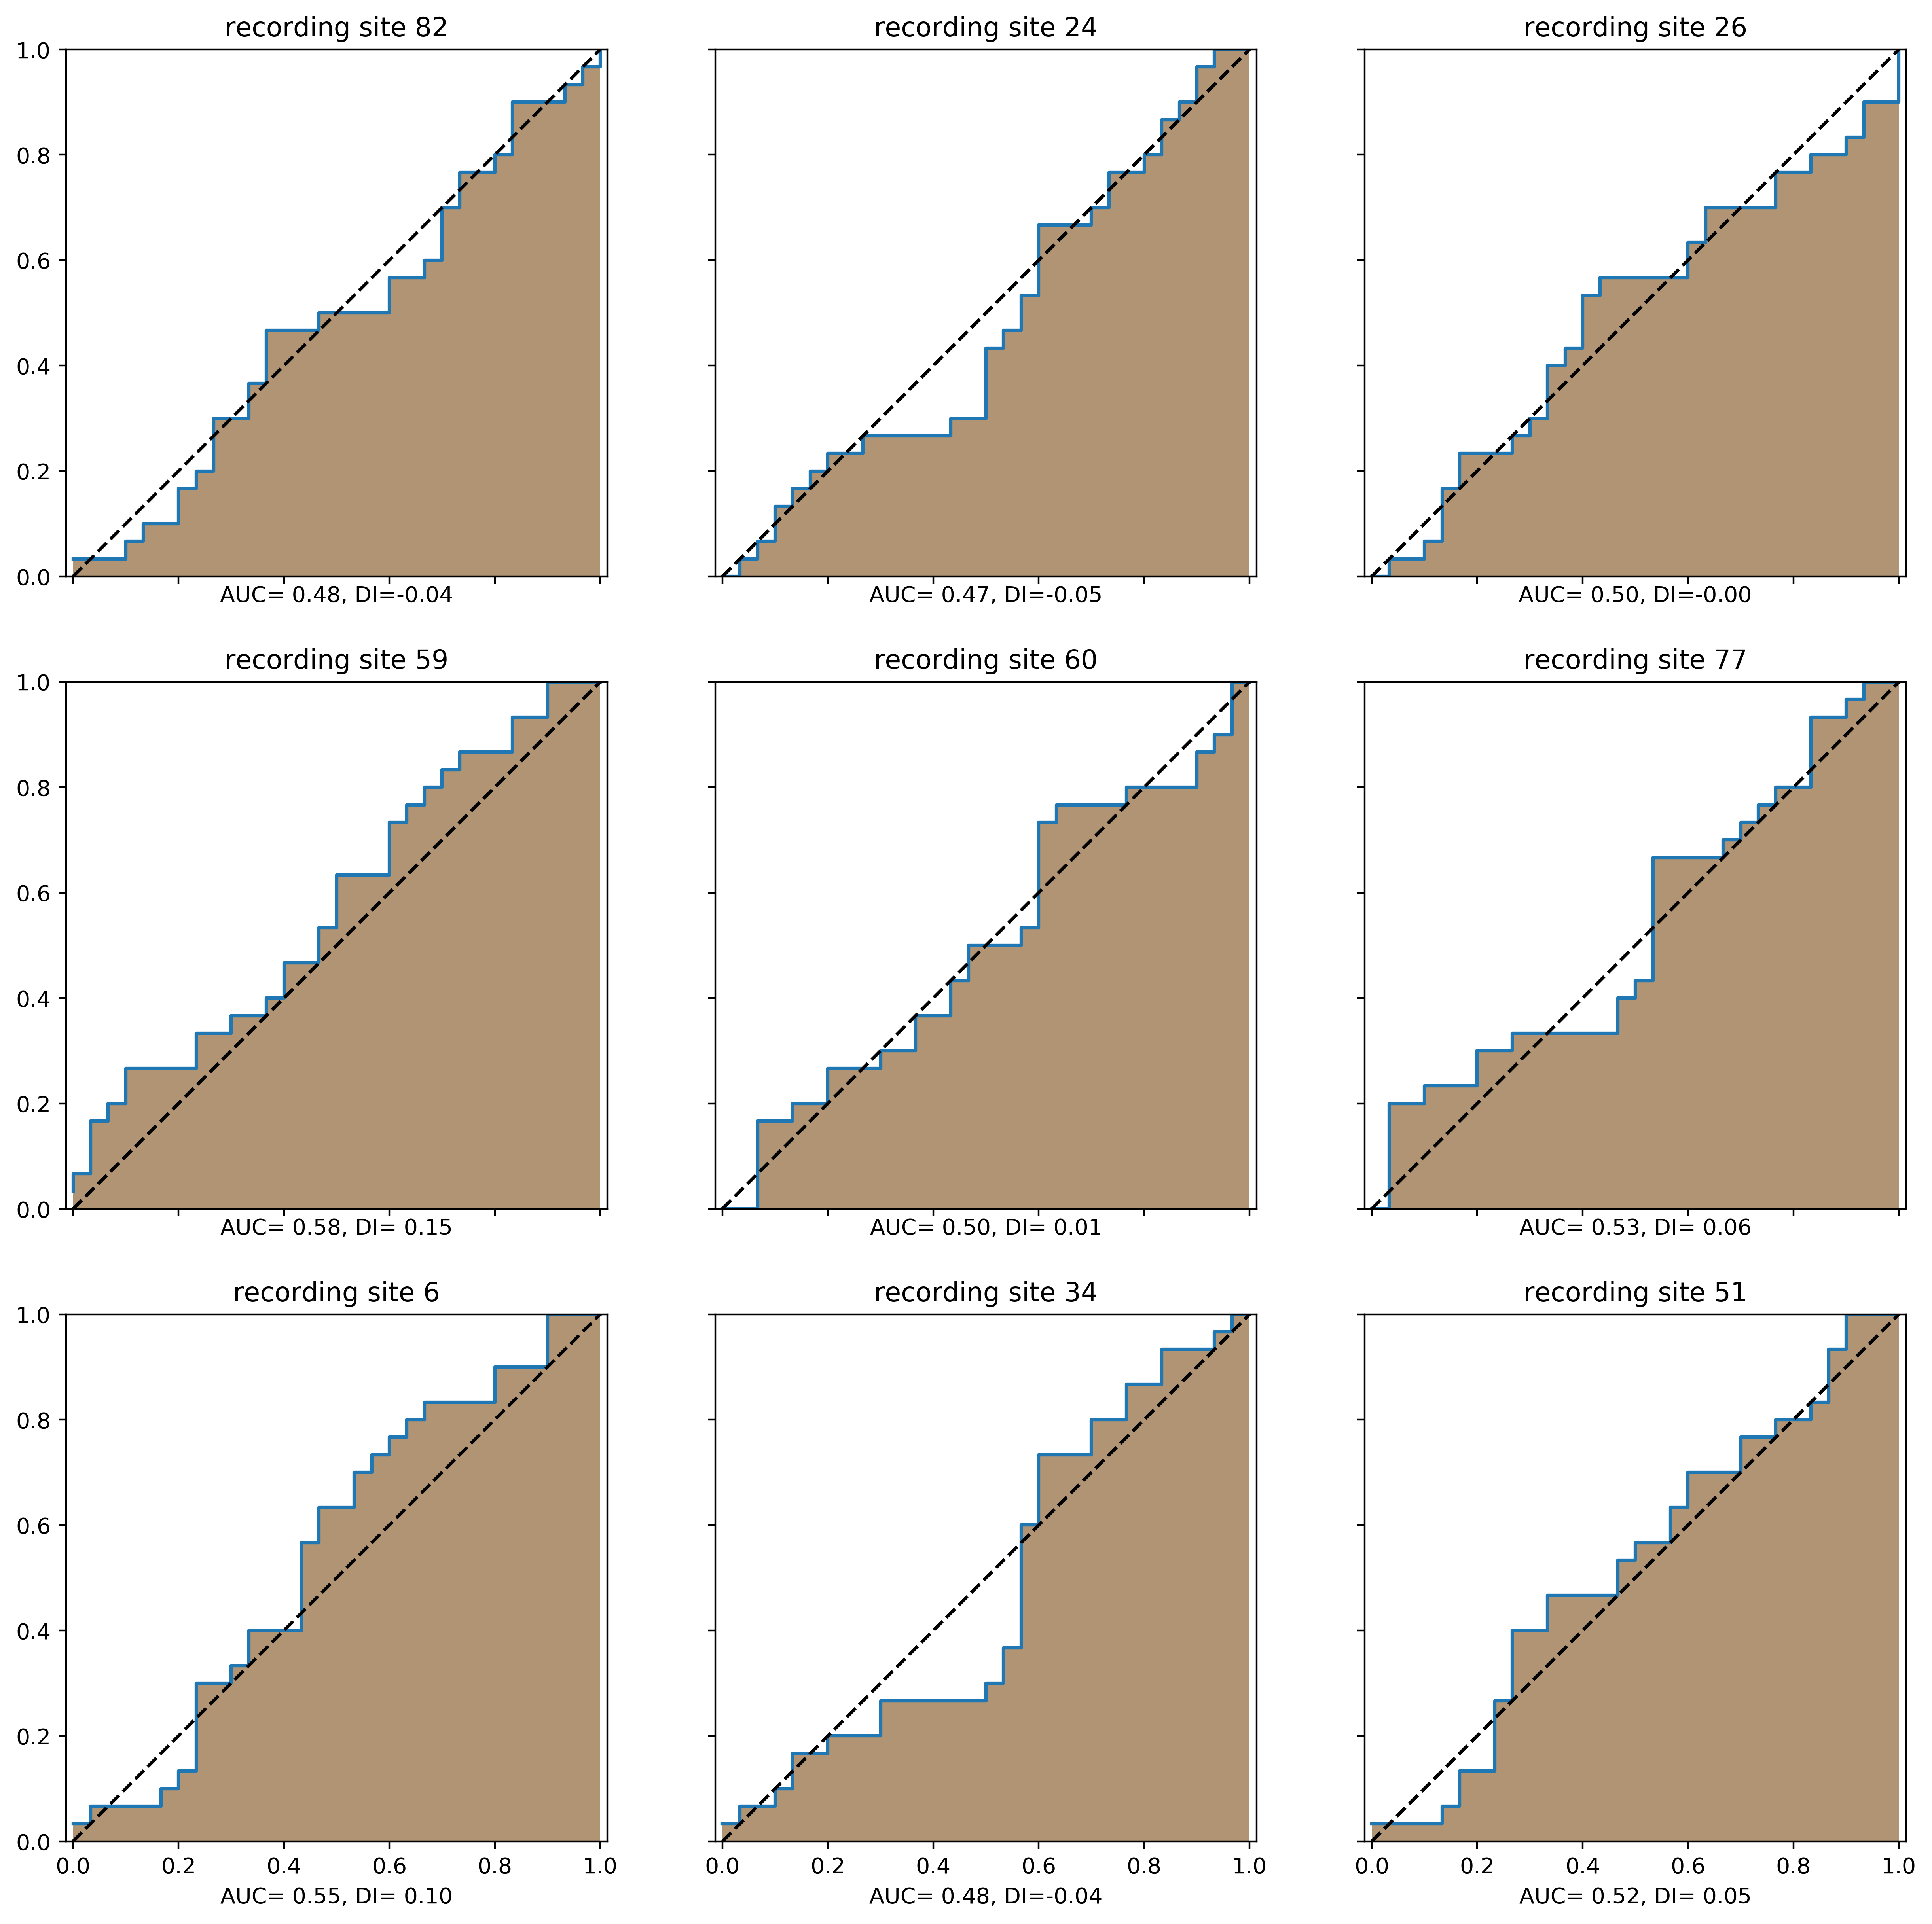

In [277]:
filename = filelist[2]
stim_amp = 2
n_dendrites = h5py.File(filename+".hdf5", "r")['data'].shape[1]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(15,15), dpi=400)
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for k, i in enumerate(np.random.choice(n_dendrites, 9, replace=False)):
    AUC = ROC_sk(filename, stim_amp, i, axes[k])
    axes[k].set_title('recording site {}'.format(i))
    axes[k].set_xlabel('AUC={0: .2f}, DI={1: .2f}'.format(AUC, (AUC-0.5)*2))

In [204]:
np.sum(fp)

61.039999999999999